Using the single electron Schrödinger equation solver

This tutorial will show how to use the qutils to solve the single electron Schrödinger equation for either 1D or 2D potential landscapes. Make sure you are running this tutorial notebook from the tutorials folder in the qudipy repo.


## 1. First load the relevant modules and initialize SimulationParameters

In [1]:
# Since we don't actually have a package yet for people to install.. 
# We need to add our folder to the PYTHONPATH in order for import to find qudipy
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

In [2]:
from qudipy.utils import constants
import qudipy.potential as pot
import qudipy.qutils as qt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
# Initialize the Material class with the Si/SiO2 material system 
mat_system = constants.select_material('Si/SiO2')

## 2a. 1D Schrödinger equation: initialize GridParameters class
Now we will create a GridParameters object with data for a Harmonic oscillator.

In [4]:
# First define the x-coordinates
x = np.linspace(-70,70,301)*1E-9
# Define harmonic oscillator frequency
omega = 5E12
# Now construct the harmonic potential
harm_pot = 1/2*mat_system.me*omega**2*np.square(x)
    
# Create a GridParameters object
gparams = pot.GridParameters(x, potential=harm_pot)

## 2b. 1D Schrödinger equation: use qutils to solve schrodinger equation

In [5]:
# Pass sparams, gparams to the solve_schrodinger_eq qutils method to obtain the eigenvalues and eigenvectors
e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(mat_system, gparams, n_sols=6)

## 2c. Check results
Our energies should have constant spacing (within some error which can be reduced by increasing the
number of x-coordinate points). The energy spacing should be equal to $\hbar \omega$.

In [6]:
print(f"Energies = {np.real(e_ens)/constants.e} eV")
print(f"hbar*omega = {constants.hbar*omega/constants.e} eV")
print(f"Calculated energy diffs = {np.diff(np.real(e_ens))/constants.e} eV")

Energies = [0.00164535 0.00493567 0.00822525 0.01151409 0.01480219 0.01808955] eV
hbar*omega = 0.003291059784754533 eV
Calculated energy diffs = [0.00329032 0.00328958 0.00328884 0.0032881  0.00328736] eV


Looks close enough! You can play around with increasing number of x-coordinate points to reduce the error. Now let's plot the first few wavefunctions...

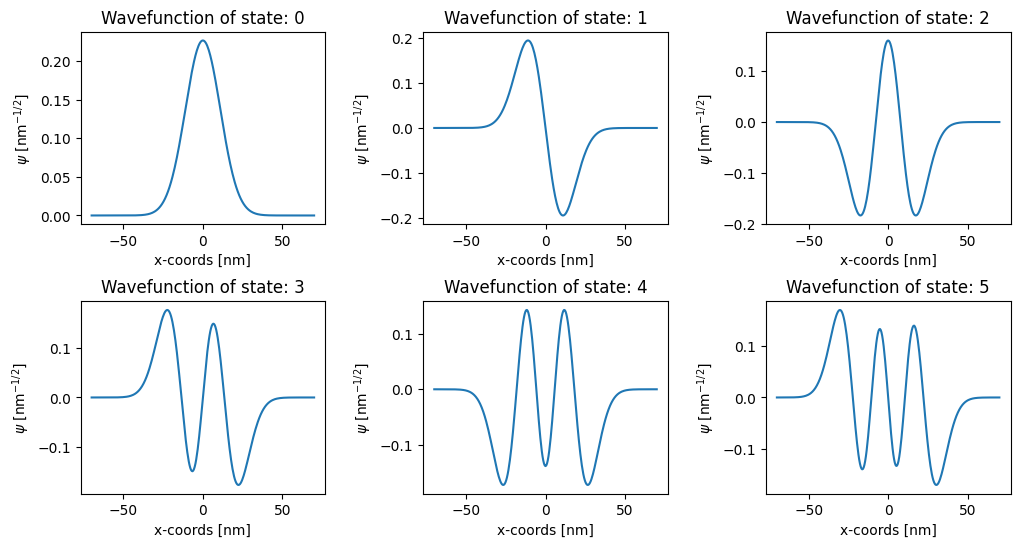

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))#,
                         #subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, ax in enumerate(axes.flat):
    ax.plot(gparams.x/1E-9, np.real(e_vecs[:,idx]) / np.sqrt(1e9))
    ax.set_title("Wavefunction of state: "+str(idx))
    ax.set(xlabel='x-coords [nm]')
    ax.set(ylabel='$\\psi\ [\\mathrm{nm}^{-{1}/{2}}]$')

plt.show()

Now plotting the probability densities:

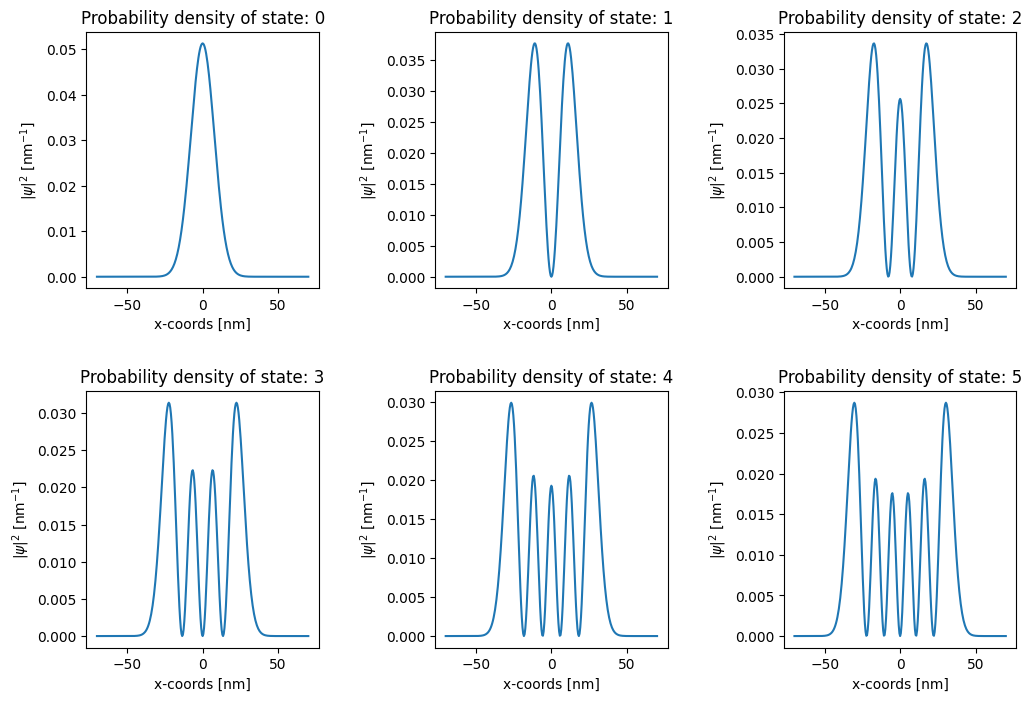

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

fig.subplots_adjust(hspace=0.4, wspace=0.5)

for idx, ax in enumerate(axes.flat):
    ax.plot(gparams.x/1E-9, np.abs(e_vecs[:,idx])**2/ 1e9 );
    ax.set_title("Probability density of state: "+str(idx))
    ax.set(xlabel='x-coords [nm]')
    ax.set(ylabel='$\\vert\\psi\\vert^2\ [\\mathrm{nm}^{-1}]$')
    
plt.show()

These look exactly as we expect. So now let's do an example for 2D potentials...
# 3a. 2D Schrödinger equation: initialize GridParameters class
Let's create a new GridParameters object with data for a 2D Harmonic oscillator.

In [9]:
# First define the x(y)-coordinates
x = np.linspace(-60,60,201) * 1E-9
y = np.linspace(-60,60,201) * 1E-9
# Define harmonic oscillator frequency
omega = 5E12

# Now initialize the GridParameters class
gparams = pot.GridParameters(x, y)
# Now construct the harmonic potential
harm_pot = (1/2 * mat_system.me * omega ** 2 *
                (np.square(gparams.x_mesh) + np.square(gparams.y_mesh)))

# Update the potential for gparams
gparams.update_potential(harm_pot)

## 3b. 2D Schrödinger equation: use qutils to solve schrodinger equation

In [10]:
# Pass sparams, gparams to the solve_schrodinger_eq qutils method to obtain
# the eigenvalues and eigenvectors
e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(mat_system, gparams, n_sols=6)

## 3c. Check results
We expect the 1st and 2nd excited states to be degenerate since they correspond to the (1,0) and (0,1) 2D harmonic orbital modes (n,m).

In [11]:
print(f"Energies = {np.real(e_ens)/constants.e} eV")
print(f"hbar*omega = {constants.hbar*omega/constants.e} eV")
print(f"Calculated energy diffs = {np.diff(np.real(e_ens))/constants.e} eV")

Energies = [0.00329045 0.00658029 0.00658029 0.0098689  0.0098689  0.00987012] eV
hbar*omega = 0.003291059784754533 eV
Calculated energy diffs = [3.28983763e-03 7.04338431e-18 3.28861491e-03 1.05650765e-17
 1.22271809e-06] eV


Looks good.  Now let's plot the wavefunctions.

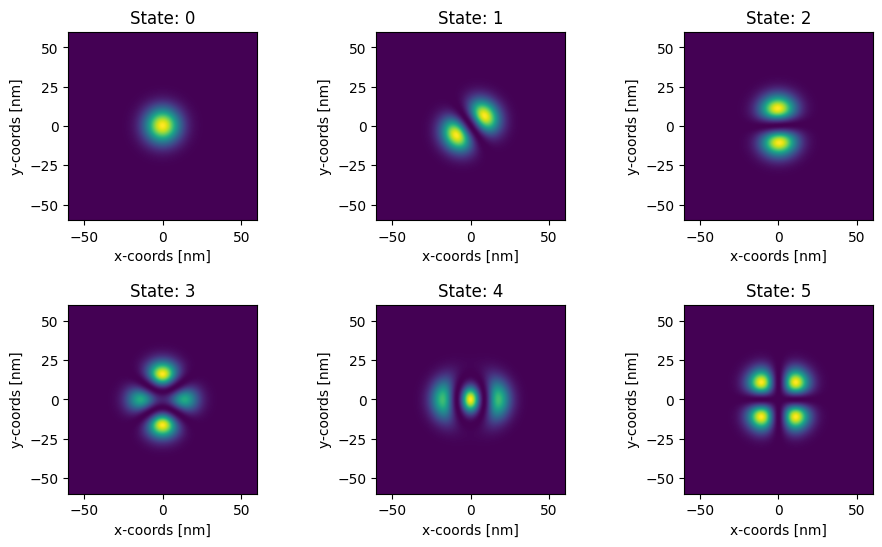

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))#,
                         #subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.45, wspace=0.3)

for idx, ax in enumerate(axes.flat):
    #ax.imshow(gparams.potential, cmap='viridis', 
    ax.imshow(np.real(np.multiply(e_vecs[:,:,idx],e_vecs[:,:,idx].conj())), 
                    extent=[gparams.x.min()/1E-9, gparams.x.max()/1E-9,
                            gparams.y.min()/1E-9, gparams.y.max()/1E-9],
                                cmap='viridis')
                                
    ax.set_title("State: "+str(idx))
    ax.set(xlabel='x-coords [nm]',ylabel='y-coords [nm]')

plt.show()

We expect the eigenfunctions to be the product of the 1D harmonic orbital states $\phi_{n,m}(x,y) = \phi_n(x)\phi_m(y)$. Of course, not all these states look like that.. But when two eigenfunctions have the same eigenvalue their linear combination is also an eigenfunction. For instance, state 1 is actually a linear combination of the equal energy states $\phi_{0,1}$ and $\phi_{1,0}$
$$\phi_1(x,y) = \alpha\ \phi_{0,1}(x,y) + \sqrt{1+\alpha^2}\ \phi_{0,1}(x,y))$$
where $\alpha$ is some constant. So these 2D eigenfunctions are correct!